epoch: 100, 对'time traveller'的预测:time traveller and the this this this this this this this this t
epoch: 200, 对'time traveller'的预测:time traveller a focisting bo exumenthe former the permen thidge
epoch: 300, 对'time traveller'的预测:time traveller ffocesso bime sughe the soim and wh hew all poren
epoch: 400, 对'time traveller'的预测:time traveller for so it will be convenient to speak of himwas e
epoch: 500, 对'time traveller'的预测:time travelleryou can show black is white by argument said filby
困惑度1.03, 188281.4词元/秒 在cuda:0上
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


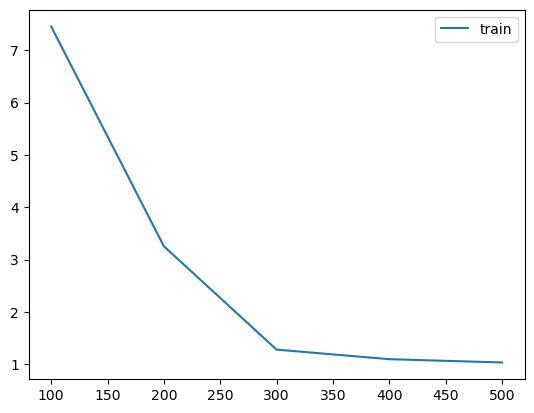

In [1]:
import utils, torch
from torch import nn
from torch.nn import functional as F

"""
独热编码:
独热编码将每个索引映射为相互不同的单位向量:假设词表中不同词元的数目为N(即len(vocab)),
词元索引的范围为0到N-1。如果词元的索引是整数i,那么将创建一个长度为N的全0向量,并将第i处的元素设置为1。
此向量是原始词元的一个独热向量。
 
每次采样的小批量数据形状是二维张量:(批量大小,时间步数)。
one_hot函数将这样一个小批量数据转换成三维张量,张量的最后一个维度等于词表大小(len(vocab))。
转换输入的维度，以便获得形状为（时间步数，批量大小，词表大小）的输出。
这将能够更方便地通过最外层的维度，一步一步地更新小批量数据的隐状态
"""

def rnn_forward(inputs, state, params):
    """
    rnn_forward函数定义了如何在一个时间步内计算隐状态和输出。
    循环神经网络模型通过inputs最外层的维度实现循环,以便逐时间步更新小批量数据的隐状态H。
    这里使用tanh函数作为激活函数,是因为当元素在实数上满足均匀分布时,tanh函数的平均值为0。

    inputs: 形状为(时间步数量, 批量大小, 词表大小)\n
    state: 上一时间步的隐状态，张量变量，形状为(批量大小,隐藏单元数)
    params: 包含三个权重矩阵和两个偏差向量。
    """
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.matmul(X, W_xh) + torch.matmul(H, W_hh) + b_h)
        Y = torch.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return torch.concat(outputs, dim=0), (H,)

class RNN():
    def __init__(self, vocab_size, num_hiddens, forward_fn, device) -> None:
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = self.get_params(vocab_size, num_hiddens, device)
        self.init_state = self.init_rnn_state
        self.forward_fn = forward_fn

    def __call__(self, X, state):
        """
        X : 形状为(批量大小, 时间步数量)\n
        state : 前一个时间步的隐状态，张量变量，形状为(批量大小,隐藏单元数)
        """
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self, batch_size, device):
        return self.init_rnn_state(batch_size, self.num_hiddens, device)
        
    def get_params(self, vocab_size, num_hiddens, device):
        """
        初始化模型参数\n
        vocab_size: 词表大小\n
        num_hiddens: 隐藏单元个数 是可调的超参数
        """
        def normal(shape):
            return torch.randn(size=shape, device=device) * 0.01

        num_inputs = num_outputs = vocab_size # 训练语言模型时,输入和输出来自相同的词表。因此它们具有相同的维度，即词表的大小。
        # 隐藏层参数
        W_xh = normal((num_inputs, num_hiddens))
        W_hh = normal((num_hiddens, num_hiddens))
        b_h = torch.zeros(num_hiddens, device=device)
        # 输出层参数
        W_hq = normal((num_hiddens, num_outputs))
        b_q = torch.zeros(num_outputs, device=device)
        # 附加梯度
        params = [W_xh, W_hh, b_h, W_hq, b_q]
        for param in params:
            param.requires_grad_(True)
        return params

    def init_rnn_state(self, batch_size, num_hiddens, device):
        """
        一个在初始化RNN时返回隐状态的函数\n
        隐状态可能包含多个变量的情况，使用元组可以更容易地处理些,所以返回元组。\n
        返回值 : 一个全用0填充的张量,形状为(批量大小,隐藏单元数)。
        """
        return (torch.zeros((batch_size, num_hiddens), device=device),)
    
def predict_rnn(prefix, num_preds, net, vocab, device):
    """
    这个函数用于在prefix后面生成新字符\n
    prefix : 一个用户提供的包含多个字符的字符串\n
    在循环遍历prefix中的开始字符时,不断地将隐状态传递到下一个时间步，但是不生成任何输出。称为预热(warm-up)期,
    在此期间模型会自我更新(例如，更新隐状态),但不会进行预测。
    预热期结束后，隐状态的值通常比刚开始的初始值更适合预测，从而预测字符并输出它们。
    """
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]: # 预热期
        _, state = net(get_input(), state) # 更新隐状态
        outputs.append(vocab[y])
    for _ in range(num_preds): # 预测num_preds步
        y, state = net(get_input(), state) # 预测y并更新隐状态
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return  ''.join([vocab.idx_to_token[i] for i in outputs])

batch_size = 32
num_epochs, lr = 500, 1
num_steps = 35
num_hiddens = 512
train_iter, vocab = utils.load_time_machine_data(batch_size, num_steps)
net = RNN(len(vocab), num_hiddens, rnn_forward, device=utils.try_gpu())
utils.rnn_train(net, train_iter, vocab, lr, num_epochs, device=utils.try_gpu())